In [1]:
import pandas as pd
# Load data code goes here
train_df = pd.read_csv('train_dataset.csv')
test_df = pd.read_csv('test_dataset.csv')

X_train = train_df[['X_train_0', 'X_train_1', 'X_train_2', 'X_train_3', 'X_train_4']].to_numpy()
y_train = train_df[['y_train']].to_numpy()
X_test = test_df[['X_test_0', 'X_test_1', 'X_test_2', 'X_test_3', 'X_test_4']].to_numpy()
y_test = test_df[['y_test']].to_numpy()

In [2]:
# (a)
from pyod.models.knn import KNN
clf = KNN() # initialize KNN class using the default parameters

# fit the model using X_train
# YOUR CODE SHOULD COME HERE
clf.fit(X_train, y_train)

s:\Varun_Projects\Assignments\AML_HW\AML\lib\site-packages\pyod\models\base.py:410: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


KNN(algorithm='auto', contamination=0.1, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
  radius=1.0)

In [3]:
from pyod.utils.data import evaluate_print
# from pyod.models.knn import decision_function

# predict the outlier labels of X_test using the trained model, compute the raw outlier scores on X_test using decision_function()
# then use evaluate_print() to print out the evaluation results

raw_outlier_scores = clf.decision_function(X_test)
evaluate_print(clf, y_test, raw_outlier_scores)

KNN(algorithm='auto', contamination=0.1, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
  radius=1.0) ROC:0.9044, precision @ rank n:0.5


s:\Varun_Projects\Assignments\AML_HW\AML\lib\site-packages\pyod\models\base.py:410: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


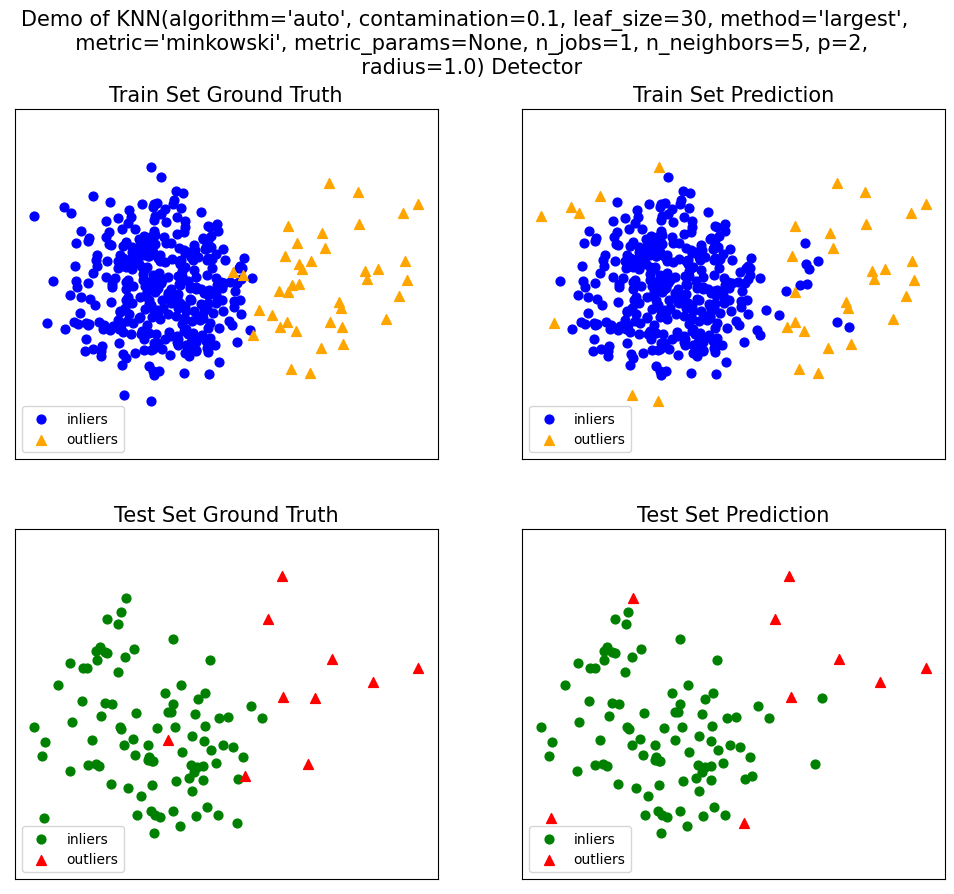

In [4]:
# (b)
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

# Fit pca to X_train and X_test and transform 
train_principalComponents = pca.fit_transform(X_train)
test_principalComponents = pca.fit_transform(X_test)

from pyod.utils.example import visualize
# Visualize the ground truth outliers and predicted outliers using visualize()
clf.fit(train_principalComponents, y_train)
y_train_pred = clf.predict(train_principalComponents)
y_test_pred = clf.predict(test_principalComponents)
visualize(clf, train_principalComponents, y_train.ravel(), test_principalComponents, y_test.ravel(), y_train_pred, y_test_pred, show_figure=True)

s:\Varun_Projects\Assignments\AML_HW\AML\lib\site-packages\pyod\models\base.py:410: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


INNE(contamination=0.1, max_samples='auto', n_estimators=200,
   random_state=None) ROC:0.8411, precision @ rank n:0.6


s:\Varun_Projects\Assignments\AML_HW\AML\lib\site-packages\pyod\models\base.py:410: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


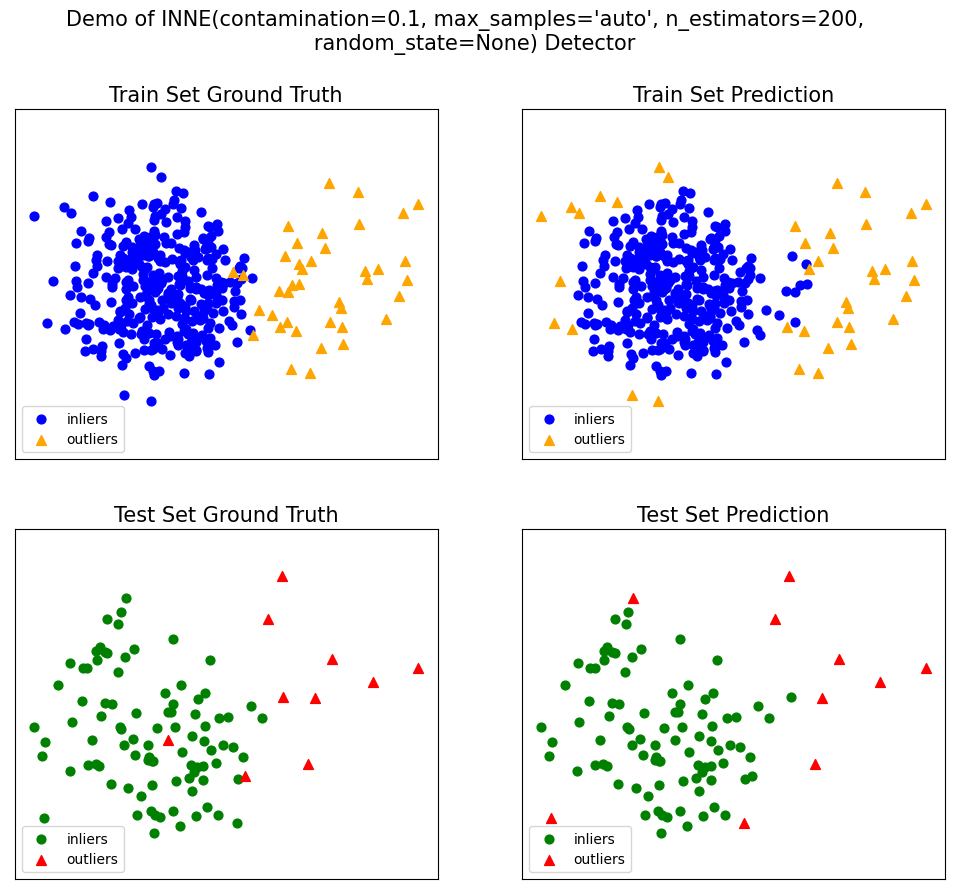

In [5]:
# (c)
from pyod.models.inne import INNE

clf = INNE()
clf.fit(X_train, y_train)

raw_outlier_scores = clf.decision_function(X_test)
evaluate_print(clf, y_test, raw_outlier_scores)

# Visualize the ground truth outliers and predicted outliers using visualize()
clf.fit(train_principalComponents, y_train)
y_train_pred = clf.predict(train_principalComponents)
y_test_pred = clf.predict(test_principalComponents)
visualize(clf, train_principalComponents, y_train.ravel(), test_principalComponents, y_test.ravel(), y_train_pred, y_test_pred, show_figure=True)

||**KNN**|**INNE**|
| --- | --- | --- |
|**ROC SCORE**|0.9044|0.8656|
|**Precision@n**|0.5|0.5|

We can observe that KNN is higher than INNE when comparing the area under the ROC curve. This means that KNN does a better job of classifying outliers.
Furthermore, the precision@n values are the same for both models. This means that when the data was an outlier, both models were accurate 50% of the time. From the figures, we can see that INNE especially avoids overlapping with the training and testing sets when compared to KNN and produces outliers only outside the main cluster. KNN allows for some overlap.

## Pre-processing and sampling (15 pts)

In [6]:
import pandas as pd 
import numpy as np 
import scipy.stats as stats
import math
import matplotlib.pyplot as plt
np.random.seed(100)

data = pd.read_csv("sales_data.csv")
data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,...,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SalePrice
0,60,RL,65.0,8450,NaN,7,5,2003,2003,196.0,...,0,0,0,NaN,NaN,NaN,0,2,2008,208500
1,20,RL,80.0,9600,NaN,6,8,1976,1976,0.0,...,0,0,0,NaN,NaN,NaN,0,5,2007,181500
2,60,RL,68.0,11250,NaN,7,5,2001,2002,162.0,...,0,0,0,NaN,NaN,NaN,0,9,2008,223500
3,70,RL,60.0,9550,NaN,7,5,1915,1970,0.0,...,0,0,0,NaN,NaN,NaN,0,2,2006,140000
4,60,RL,84.0,14260,NaN,8,5,2000,2000,350.0,...,0,0,0,NaN,NaN,NaN,0,12,2008,250000


In [7]:
Nulls = data.isna().sum()
print(Nulls.sum())
Nulls

6527


MSSubClass          0
MSZoning            0
LotFrontage       259
LotArea             0
Alley            1369
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
MasVnrArea          8
ExterQual           0
BsmtFinSF1          0
BsmtFinSF2          0
BsmtUnfSF           0
TotalBsmtSF         0
HeatingQC           0
CentralAir          0
Electrical          1
1stFlrSF            0
2ndFlrSF            0
LowQualFinSF        0
GrLivArea           0
BsmtFullBath        0
BsmtHalfBath        0
FullBath            0
HalfBath            0
BedroomAbvGr        0
KitchenAbvGr        0
KitchenQual         0
TotRmsAbvGrd        0
Functional          0
Fireplaces          0
FireplaceQu       690
GarageType         81
GarageYrBlt        81
GarageCars          0
GarageArea          0
WoodDeckSF          0
OpenPorchSF         0
EnclosedPorch       0
3SsnPorch           0
ScreenPorch         0
PoolArea            0
PoolQC           1453
Fence            1179
MiscFeatur

In [8]:
data.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Alley',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'ExterQual', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC',
       'Fence', 'MiscFeature', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [9]:
from sklearn.preprocessing import OneHotEncoder

data_dm = data.copy()
data_dm['binned_garage_yr_built'] = pd.cut(data['GarageYrBlt'], bins=[1900, 1930, 1960, 1990, 2020], 
                                           labels=['1900-1930', '1930-1960', '1960-1990', '1990-2020'], 
                                           include_lowest=True)

data_dm.head()


# assigning numerical values and storing them in another column
one_hot = pd.get_dummies(data_dm['binned_garage_yr_built'])
one_hot

,1900-1930,1930-1960,1960-1990,1990-2020
0,0,0,0,1
1,0,0,1,0
2,0,0,0,1
3,0,0,0,1
4,0,0,0,1
...,...,...,...,...
1455,0,0,0,1
1456,0,0,1,0
1457,0,1,0,0
1458,0,1,0,0


In [10]:
# 90%
data_90 = data_dm.copy()
columns_null_90 = list(data.columns.values[data.isnull().mean()>0.9])
number_dropped_90 = len(columns_null_90)
print(f"Columns with 90% null values that are getting dropped are {columns_null_90}")
print(f"The number of columns that get dropped after 90% null values: {number_dropped_90}")
data_90 = data_90.drop(columns=columns_null_90)

# 95%
data_95=data_dm.copy()
columns_null_95 = list(data.columns.values[data.isnull().mean()>0.95])
number_dropped_95 = len(columns_null_95)
print(f"Columns with 95% null values that are getting dropped are {columns_null_95}")
print(f"The number of columns that get dropped after 95% null values: {number_dropped_95}")
data_95 = data_95.drop(columns=columns_null_95)

# 98%
data_98= data_dm.copy()
columns_null_98 = list(data.columns.values[data.isnull().mean()>0.98])
number_dropped_98 = len(columns_null_98)
print(f"Columns with 98% null values that are getting dropped are {columns_null_98}")
print(f"The number of columns that get dropped after 98% null values: {number_dropped_98}")
data_98 = data_98.drop(columns=columns_null_98)

Columns with 90% null values that are getting dropped are ['Alley', 'PoolQC', 'MiscFeature']
The number of columns that get dropped after 90% null values: 3
Columns with 95% null values that are getting dropped are ['PoolQC', 'MiscFeature']
The number of columns that get dropped after 95% null values: 2
Columns with 98% null values that are getting dropped are ['PoolQC']
The number of columns that get dropped after 98% null values: 1


In [11]:
np.random.seed(6)
sample_ages = np.random.choice(a= data['SalePrice'], size=800)

#Sample mean
sample_mean = sample_ages.mean()
print(f"Sample mean is {sample_mean}")

#Population mean
population_mean = data['SalePrice'].mean()
print(f"Population mean is {population_mean}")

Sample mean is 178292.63125
Population mean is 180921.19589041095


In [12]:
import scipy.stats
import statistics

np.random.seed(10)
sample_size = 100
sample = np.random.choice(a= data['SalePrice'],
                          size = sample_size)
sample_mean = sample.mean()

#Get the critical Z value
z_critical = scipy.stats.norm.ppf(.05)

#Get population standard deviation

pop_stdev = statistics.stdev(data['SalePrice'])

#margin of error
margin_of_error = z_critical * (pop_stdev/math.sqrt(sample_size)) 

#confidence interval
confidence_interval = (sample_mean - margin_of_error,
                       sample_mean + margin_of_error)  

#Print confidence interval and true mean value

print(f"Confidence_interval for sample size of 100 is {confidence_interval}")

Confidence_interval for sample size of 100 is (195159.65890010187, 169025.40109989812)


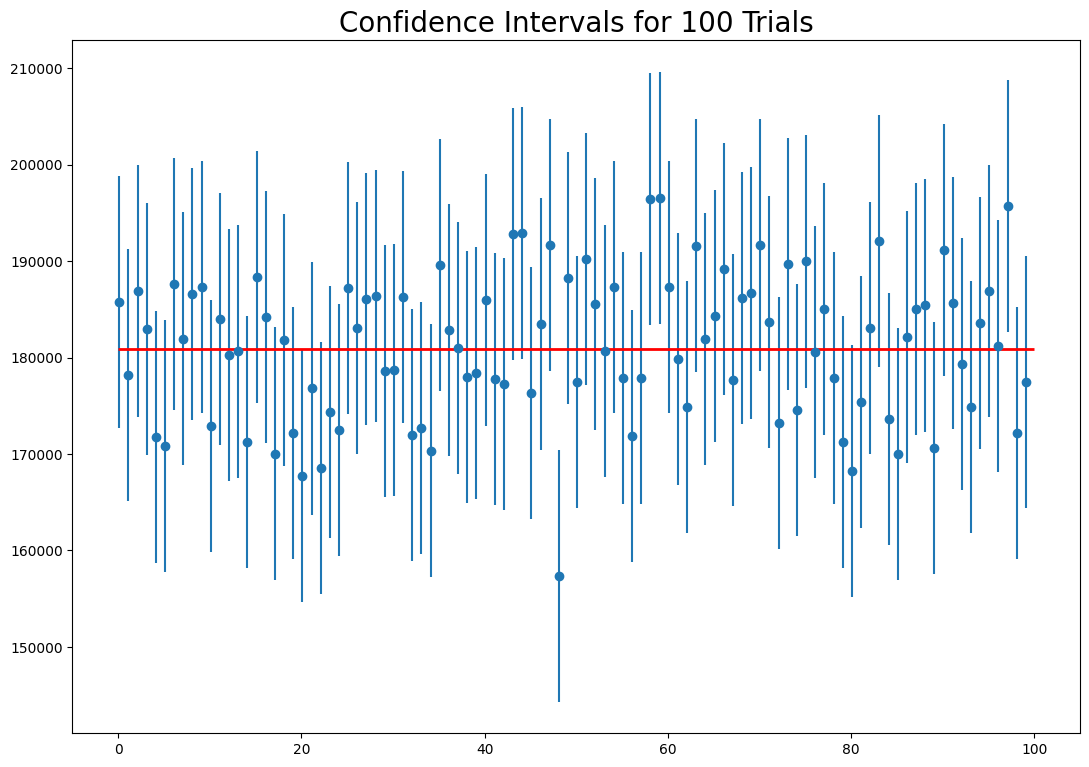

In [13]:
np.random.seed(12)

#define the sample size

intervals = []
sample_means = []

for sample in range(100):
    sample = np.random.choice(a= data_dm['SalePrice'], size = sample_size)
    sample_mean = sample.mean()
    sample_means.append(sample_mean)
    #compute z critical value

    #compute population std dev        
  
    
    margin_of_error = z_critical * (pop_stdev/math.sqrt(sample_size))
    confidence_interval = (sample_mean - margin_of_error,
                           sample_mean + margin_of_error)  
    
    intervals.append(confidence_interval)
    

plt.figure(figsize=(13, 9))

plt.errorbar(x=np.arange(0.1, 100, 1), 
             y=sample_means, 
             yerr=[(top-bot)/2 for top,bot in intervals],
             fmt='o')

plt.hlines(xmin=0, xmax=100,
           y=data['SalePrice'].mean(), 
           linewidth=2.0,
           color="red")
plt.title('Confidence Intervals for 100 Trials', fontsize = 20)
plt.show()

In [14]:
print("Mean of all the sample means:", np.mean(sample_means))
print("Population Mean:",data['SalePrice'].mean())

Mean of all the sample means: 181135.81100000002
Population Mean: 180921.19589041095


It is understood that the mean of all the 100 sample means is closely matching to that of true population , so it is indicating that the samples correctly capturing the population mean as per Central Limit Theorem